In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

from pyspark.ml.feature import Word2Vec, Tokenizer
from pyspark.ml import Pipeline 
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.clustering import KMeans

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# create a SparkSession
spark = SparkSession.builder.appName('access_logs').getOrCreate()

In [3]:
# read log file in RDD
file_path = 'sample_logs1.txt'   # access_logs_201612.txt
raw_logs = spark.sparkContext.textFile(file_path)
raw_logs.count()

282695

In [4]:
# create data frame
parsed_logs = raw_logs.map(lambda x: Row(raw = x))
df_logs = spark.createDataFrame(parsed_logs)

# add column of index
indexed_logs = df_logs.withColumn("idx", F.monotonically_increasing_id())
windowSpec = W.orderBy("idx")
indexed_logs.withColumn("idx", F.row_number().over(windowSpec))

indexed_logs.printSchema()
indexed_logs.show(3)

root
 |-- raw: string (nullable = true)
 |-- idx: long (nullable = false)

+--------------------+---+
|                 raw|idx|
+--------------------+---+
|147.214.18.128 - ...|  0|
|147.214.18.128 - ...|  1|
|localhost - - 201...|  2|
+--------------------+---+
only showing top 3 rows



In [5]:
# transformation from raw log line to tokens & show
tokenizer = Tokenizer(inputCol="raw", outputCol="tokens")
tokensData = tokenizer.transform(indexed_logs)
tokensData.show(3)

+--------------------+---+--------------------+
|                 raw|idx|              tokens|
+--------------------+---+--------------------+
|147.214.18.128 - ...|  0|[147.214.18.128, ...|
|147.214.18.128 - ...|  1|[147.214.18.128, ...|
|localhost - - 201...|  2|[localhost, -, -,...|
+--------------------+---+--------------------+
only showing top 3 rows



In [6]:
# Learn a mapping from words to Vectors.
vecModel = Word2Vec(vectorSize=16, minCount=0, inputCol="tokens", outputCol="vec").fit(tokensData)
vecData = vecModel.transform(tokensData)
vecData.show()

+--------------------+---+--------------------+--------------------+
|                 raw|idx|              tokens|                 vec|
+--------------------+---+--------------------+--------------------+
|147.214.18.128 - ...|  0|[147.214.18.128, ...|[0.02898259926587...|
|147.214.18.128 - ...|  1|[147.214.18.128, ...|[0.02489781172739...|
|localhost - - 201...|  2|[localhost, -, -,...|[0.31840608449419...|
|147.214.18.128 - ...|  3|[147.214.18.128, ...|[0.00519319737537...|
|147.214.18.128 - ...|  4|[147.214.18.128, ...|[0.01105898823071...|
|147.214.18.128 - ...|  5|[147.214.18.128, ...|[0.02053154865279...|
|147.214.18.128 - ...|  6|[147.214.18.128, ...|[0.06550943254328...|
|147.214.18.128 - ...|  7|[147.214.18.128, ...|[0.11578032829086...|
|147.214.18.128 - ...|  8|[147.214.18.128, ...|[0.09773356953842...|
|147.214.18.128 - ...|  9|[147.214.18.128, ...|[-0.0156739802203...|
|147.214.18.128 - ...| 10|[147.214.18.128, ...|[0.14237827078128...|
|147.214.18.128 - ...| 11|[147.214

In [7]:
# Build pipeline combining the previous transformations
pipeline = Pipeline(stages=[tokenizer, vecModel]) 

# Fit the pipeline 
model = pipeline.fit(indexed_logs) 

# Make a prediction 
featured_logs = model.transform(indexed_logs)

featured_logs.show(5)

+--------------------+---+--------------------+--------------------+
|                 raw|idx|              tokens|                 vec|
+--------------------+---+--------------------+--------------------+
|147.214.18.128 - ...|  0|[147.214.18.128, ...|[0.02898259926587...|
|147.214.18.128 - ...|  1|[147.214.18.128, ...|[0.02489781172739...|
|localhost - - 201...|  2|[localhost, -, -,...|[0.31840608449419...|
|147.214.18.128 - ...|  3|[147.214.18.128, ...|[0.00519319737537...|
|147.214.18.128 - ...|  4|[147.214.18.128, ...|[0.01105898823071...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



In [8]:
# drop unnecessary columns
featured_logs = featured_logs.drop("raw", "tokens")
featured_logs.show(5)

+---+--------------------+
|idx|                 vec|
+---+--------------------+
|  0|[0.02898259926587...|
|  1|[0.02489781172739...|
|  2|[0.31840608449419...|
|  3|[0.00519319737537...|
|  4|[0.01105898823071...|
+---+--------------------+
only showing top 5 rows



In [9]:
# randomize samples from logs to try different number of clusters
# and calculate costs
c = 30
cost = np.zeros(c)
for k in range(2, c):
    kmeans = KMeans().setK(k).setFeaturesCol("vec")
    model = kmeans.fit(featured_logs.sample(False, 0.001))
    cost[k] = model.computeCost(featured_logs)

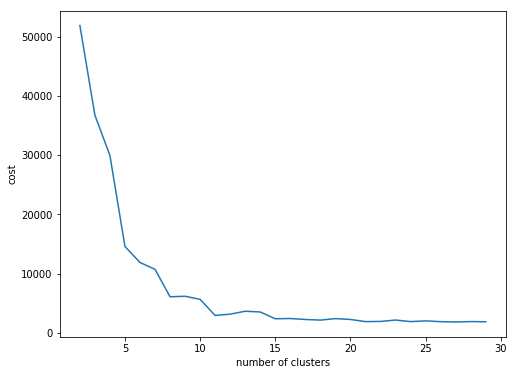

In [10]:
# plot cost curve and pick the one at elbow
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, c),cost[2: c])
ax.set_xlabel('number of clusters')
ax.set_ylabel('cost')

In [11]:
# fit model with data logs
k = 10
kmeans = KMeans().setK(k).setFeaturesCol("vec")
model = kmeans.fit(featured_logs)
cost = model.computeCost(featured_logs)
print(cost)

5723.80917191


In [12]:
# transform data frame with column of cluster prediction and show top 20 logs
clustered_logs = model.transform(featured_logs).select('idx', 'prediction')
clustered_logs.show()

+---+----------+
|idx|prediction|
+---+----------+
|  0|         7|
|  1|         5|
|  2|         9|
|  3|         7|
|  4|         7|
|  5|         5|
|  6|         1|
|  7|         1|
|  8|         0|
|  9|         7|
| 10|         0|
| 11|         0|
| 12|         0|
| 13|         0|
| 14|         0|
| 15|         0|
| 16|         0|
| 17|         0|
| 18|         0|
| 19|         0|
+---+----------+
only showing top 20 rows

